## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [1]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot

## Step 2: Load Configs
Load default config from the folder `configs/high_frequency_trading/high_frequency_trading_BTC_dqn_dqn_adam_mse.py`

In [2]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "high_frequency_trading", "high_frequency_trading_BTC_dqn_dqn_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _ = parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /data/sunshuo/qml/TradeMaster/configs/high_frequency_trading/high_frequency_trading_BTC_dqn_dqn_adam_mse.py): {'data': {'type': 'HighFrequencyTradingDataset', 'data_path': 'data/high_frequency_trading/small_BTC', 'train_path': 'data/high_frequency_trading/small_BTC/train.csv', 'valid_path': 'data/high_frequency_trading/small_BTC/valid.csv', 'test_path': 'data/high_frequency_trading/small_BTC/test.csv', 'test_dynamic_path': 'data/high_frequency_trading/small_BTC/test_labeled_3_300_-0.01_0.01.csv', 'tech_indicator_list': ['imblance_volume_oe', 'sell_spread_oe', 'buy_spread_oe', 'kmid2', 'bid1_size_n', 'ksft2', 'ma_10', 'ksft', 'kmid', 'ask1_size_n', 'trade_diff', 'qtlu_10', 'qtld_10', 'cntd_10', 'beta_10', 'roc_10', 'bid5_size_n', 'rsv_10', 'imxd_10', 'ask5_size_n', 'ma_30', 'max_10', 'qtlu_30', 'imax_10', 'imin_10', 'min_10', 'qtld_30', 'cntn_10', 'rsv_30', 'cntp_10', 'ma_60', 'max_30', 'qtlu_60', 'qtld_60', 'cntd_30', 'roc_30', 'beta_30', 'bid4_size_n', 'rsv_60', 'ask4_si

## Step 3: Build Dataset
Build datasets from cfg defined above

In [4]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and previously-defined dataset



In [5]:
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
cfg.environment = cfg.train_environment
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))

In [6]:
train_environment.df.head()

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,imxd_60,cntp_10,cntp_30,cntp_60,cntn_10,cntn_30,cntn_60,cntd_10,cntd_30,cntd_60
0,23794.3,0.900828,23792.9,0.018588,23792.8,0.007388,23792.1,0.042018,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-0.418841,-0.017993,-0.189727,0.469470,0.745885,0.877378
1,23794.3,0.000878,23793.2,0.014988,23793.1,0.147063,23792.8,0.007388,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.358007,0.891105,0.745885,1.031828
2,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.976534,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.340727
3,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.800684,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.186278
4,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.112905,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.694566,0.891105,0.745885,1.340727


In [7]:
valid_environment.df.head()

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,imxd_60,cntp_10,cntp_30,cntp_60,cntn_10,cntn_30,cntn_60,cntd_10,cntd_30,cntd_60
50000,23303.2,0.031181,23302.0,0.019908,23301.4,0.020000,23300.0,0.771447,23299.0,0.042905,...,-0.209928,-0.361983,0.081350,0.097285,-0.418841,-0.582354,-0.694566,0.047835,0.522590,0.722929
50001,23303.2,0.031181,23302.0,0.019908,23301.4,0.020000,23300.0,0.771447,23298.5,0.069680,...,-0.209928,-0.361983,0.081350,0.097285,-0.418841,-0.582354,-0.694566,0.047835,0.522590,0.722929
50002,23303.2,0.011181,23302.0,0.019908,23300.1,0.018296,23300.0,0.771447,23298.5,0.069680,...,-0.209928,-0.361983,0.081350,0.097285,-0.418841,-0.582354,-0.694566,0.047835,0.522590,0.722929
50003,23303.2,0.011181,23302.0,0.019908,23301.4,0.020000,23300.0,0.771447,23298.5,0.069680,...,-0.209928,-0.361983,-0.212761,0.097285,-0.418841,-0.582354,-0.694566,0.047835,0.299295,0.722929
50004,23303.2,0.011181,23302.0,0.019908,23301.4,0.020000,23300.0,0.771447,23298.9,0.042906,...,-0.182932,-0.361983,-0.212761,-0.078565,-0.418841,-0.582354,-0.694566,0.047835,0.299295,0.568479


In [8]:
test_environment.df.head()

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,imxd_60,cntp_10,cntp_30,cntp_60,cntn_10,cntn_30,cntn_60,cntd_10,cntd_30,cntd_60
75000,23090.7,1.404109,23090.1,0.009321,23090.0,0.127430,23089.5,0.127430,23089.1,0.00030,...,-0.722864,0.268138,-0.506873,1.152384,0.798868,2.521634,1.493069,-0.373800,-2.380241,-0.358218
75001,23090.7,1.537382,23090.5,0.108546,23090.0,0.127430,23089.5,0.127430,23089.1,0.00030,...,-0.722864,-0.361983,-0.506873,1.152384,0.798868,2.239453,1.493069,-0.795436,-2.156947,-0.358218
75002,23089.1,0.000300,23088.9,0.000730,23088.5,0.007170,23087.4,0.011701,23087.3,0.00717,...,-0.722864,0.268138,-0.212761,1.328234,0.798868,1.957272,1.324789,-0.373800,-1.710357,-0.049319
75003,23088.9,0.000730,23088.5,0.007470,23087.4,0.009441,23087.3,0.007170,23086.5,0.00105,...,-0.722864,0.268138,-0.212761,1.152384,1.407722,2.239453,1.493069,-0.795436,-1.933652,-0.358218
75004,23088.9,0.000760,23088.5,0.007470,23087.4,0.008501,23087.3,0.007170,23086.5,0.00105,...,-0.722864,0.268138,-0.212761,1.152384,2.016576,2.521634,1.493069,-1.217071,-2.156947,-0.358218


## Step 5: Build Net 
Update information about the state and action dimension in the config and create nets and optimizer for DQN


In [9]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss
Build loss from config

In [10]:
criterion = build_loss(cfg)

## Step 7: Build Agent
Build agent from config and detect device

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg,default_args=dict(action_dim=action_dim,state_dim=state_dim,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer=cri_optimizer,criterion=criterion,device=device))


## Step 8: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [12]:

trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

cfg.dump(osp.join(ROOT, cfg.work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/high_frequency_trading_BTC_high_frequency_trading_dqn_ddqn_adam_mse


## Step 9: Train the Trainer
Train the trainer based on the config and get results from workdir

In [13]:
trainer.train_and_valid()

Train Episode: [1/10]
+---------------+----------------+------------+--------------+
| Profit Margin |  Sharp Ratio   | Volatility | Max Drawdown |
+---------------+----------------+------------+--------------+
|  -26.578258%  | -300560.920569 | 0.004138%  |  26.591124%  |
+---------------+----------------+------------+--------------+
+---------------+----------------+------------+--------------+
| Profit Margin |  Sharp Ratio   | Volatility | Max Drawdown |
+---------------+----------------+------------+--------------+
|  -27.884073%  | -295720.496666 | 0.004413%  |  27.889140%  |
+---------------+----------------+------------+--------------+
Valid Episode: [1/10]
+--------------+----------------+------------+--------------+
| Total Return |  Sharp Ratio   | Volatility | Max Drawdown |
+--------------+----------------+------------+--------------+
| -38.177955%  | -310501.539184 | 0.004367%  |  38.177955%  |
+--------------+----------------+------------+--------------+
Train Episode: [

In [14]:
trainer.test()

Resume checkpoint /data/sunshuo/qml/TradeMaster/work_dir/high_frequency_trading_BTC_high_frequency_trading_dqn_ddqn_adam_mse/checkpoints/best.pth
Test Best Episode
+--------------+----------------+------------+--------------+
| Total Return |  Sharp Ratio   | Volatility | Max Drawdown |
+--------------+----------------+------------+--------------+
| -31.778419%  | -182976.791710 | 0.006168%  |  31.784243%  |
+--------------+----------------+------------+--------------+


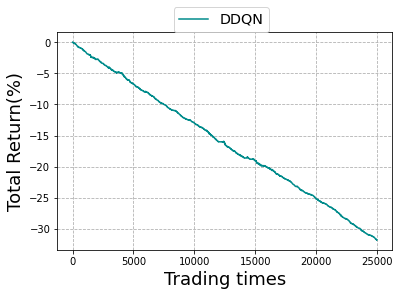

In [15]:
plot(trainer.test_environment.save_asset_memoey(),alg="DDQN")